In [1]:
!which python
!python -V

/home/vtrokhymenko/proj_news_radar/env4news/bin/python
Python 3.7.3


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import gc

%load_ext autoreload
%autoreload 2

In [3]:
# set path 
home_path = os.getenv('HOME') # создаем домашнюю директорию
dir_project = 'proj_news_radar/proj_news_viz/nlp' # прописываем путь проекта

PATH = os.path.join(home_path, dir_project)
sys.path.append(PATH)

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

---

возьмем для примера датасет [lenta.ru](https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta)

In [5]:
df = pd.read_csv(f'{PATH}/data/external/lenta-ru-news.csv.gz')
print(df.shape)
df.head(2)

(739351, 5)


,url,title,text,topic,tags
0,https://lenta.ru/news/2018/12/14/cancer/,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Общество
1,https://lenta.ru/news/2018/12/15/doping/,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Зимние виды


немного запрепроцессим датасет

In [6]:
# удалим пустые записи и дубликаты по полю `text`
df.dropna(inplace=True)
df.text.drop_duplicates(inplace=True)

print(f'df.shape: {df.shape}')
df.isnull().sum()

df.shape: (712829, 5)


url      0
title    0
text     0
topic    0
tags     0
dtype: int64

In [11]:
# посмотрим на к-ство записей по разделам
print(f'уникальное к-ство разделов: {df.topic.unique().shape[0]}')
print(f'\nих распределение:\n{df.topic.value_counts()}')

уникальное к-ство разделов: 23

их распределение:
Россия               155078
Мир                  136679
Экономика             76433
Спорт                 57902
Культура              53536
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44433
Из жизни              27519
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Оружие                    3
ЧМ-2014                   2
МедНовости                1
Сочи                      1
Name: topic, dtype: int64


In [12]:
# выберем для примера топ-5 разделов
df_top5 = df[df.topic.isin(df.topic.value_counts().head(5).index)]
df_top5.shape

(479628, 5)

---

закодируем кат-фичи

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [14]:
# обучаем энкодер
le.fit(df_top5.topic)
list(le.classes_)

['Культура', 'Мир', 'Россия', 'Спорт', 'Экономика']

In [15]:
# применяем 
le.transform(df_top5.topic) 

array([2, 3, 1, ..., 2, 2, 2])

In [16]:
# посмотрим какое число описывает раздел "Россия"
le.transform(['Россия'])

array([2])

In [17]:
# добавим новый признак заэнкодженных разделов к нашему датасету в качестве таргета
df_top5['target'] = le.transform(df_top5.topic)
df_top5.head()

df_top5.sample(5)

,url,title,text,topic,tags,target
348293,https://lenta.ru/news/2011/09/27/jagr/,Ягр забросил две шайбы в матче за клуб НХЛ,Чешский хоккеист Яромир Ягр забросил две шайбы...,Спорт,Все,3
387195,https://lenta.ru/news/2010/11/09/slit/,Обвиняемые в тюремном бунте вскрыли вены на за...,"Заключенные, подозреваемые в организации и уча...",Россия,Все,2
667143,https://lenta.ru/news/2003/06/05/madonna/,Книга Мадонны расскажет детям о еврейской мист...,"Уже первая детская книга, написанная королевой...",Культура,Все,0
707214,https://lenta.ru/news/2001/08/02/helicopter/,В Чечне обстрелян транспортный вертолет Ми-26,В Чечне боевики обстреляли транспортный вертол...,Россия,Все,2
726052,https://lenta.ru/news/2000/09/21/volleyball/,Российские волейболисты выходят в четвертьфинал,Без малого два часа продолжался матч волейболь...,Спорт,Все,3


---

сплитим данные 

In [18]:
from sklearn.model_selection import train_test_split

In [127]:
X_train, X_test, y_train, y_test = train_test_split(df_top5.text,df_top5.target,
                                                    test_size=0.2,
                                                    stratify=df_top5.target,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((383702,), (95926,), (383702,), (95926,))

In [128]:
X_train.isna().sum(), X_test.isna().sum()

(0, 0)

____

## сделаем небольшое исследование, обучив модель с и без препроцессинга

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [124]:
def plot_frequency(vocab: list=None, top_wold: int=30) -> None:
    
    x, y = [], []
    for key, val in vocab[:top_wold]:
        x.append(key)
        y.append(val)
        
    plt.figure(figsize=(20,10), )
    plt.bar(x,y)
    plt.title('топ-30 частотных слов')
    plt.xlabel('слова', horizontalalignment='center')
    plt.ylabel('частотность')
    

* ### без препроцессинга

In [129]:
%%time
count_vect = CountVectorizer(min_df=0.1)

# в данном примере обучим только на `X_train`
# но ничего не мешает обучить и на `X_test`
count_vect_train = count_vect.fit_transform(X_train)
count_vect_test = count_vect.transform(X_test)

CPU times: user 53.6 s, sys: 634 ms, total: 54.3 s
Wall time: 54.3 s


In [130]:
# распределение токенов
vocab = {a: b for a, b in zip(count_vect.get_feature_names(), np.ravel(count_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))
vocab[:10]

[('на', 1330966),
 ('по', 810857),
 ('что', 771161),
 ('не', 540556),
 ('из', 405050),
 ('за', 345535),
 ('года', 304637),
 ('как', 295152),
 ('его', 237666),
 ('он', 232889)]

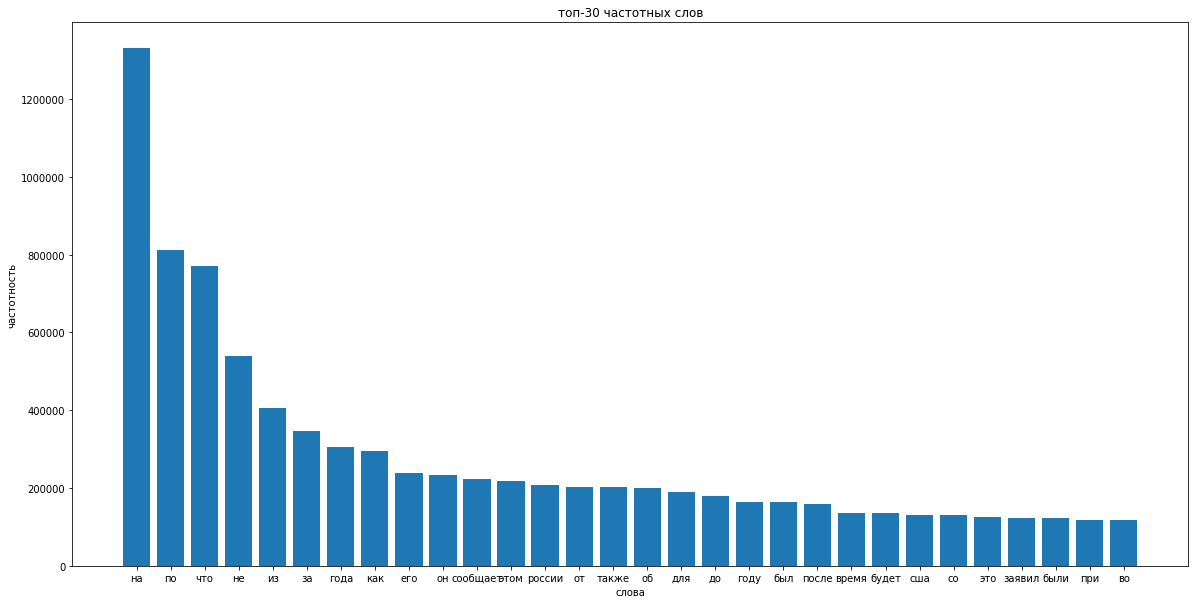

In [131]:
plot_frequency(vocab, 30)

In [57]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(count_vect_train, y_train)

pred_lr = lr.predict(count_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5, target_names=le.classes_)}')
print(f'\nconfusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.47197   0.58896   0.52402     10707
         Мир    0.70057   0.66176   0.68061     27336
      Россия    0.72500   0.63335   0.67609     31016
       Спорт    0.56351   0.71416   0.62995     11580
   Экономика    0.68267   0.66861   0.67557     15287

    accuracy                        0.65187     95926
   macro avg    0.62874   0.65337   0.63725     95926
weighted avg    0.66356   0.65187   0.65475     95926


confusion_matrix:
[[ 6306  1109  1132  1495   665]
 [ 2551 18090  3435  1910  1350]
 [ 2296  4538 19644  2242  2296]
 [ 1347   763   760  8270   440]
 [  861  1322  2124   759 10221]]
CPU times: user 1min 8s, sys: 27.9 ms, total: 1min 8s
Wall time: 1min 8s


In [26]:
# from sklearn.pipeline import Pipeline
# 
# pipe = Pipeline([('vec', CountVectorizer(min_df=0.1)),
#                 ('clf', LogisticRegression(class_weight='balanced', random_state=42))])
# 
# pipe.fit(X_train,y_train)
# 
# pred_lr = pipe.predict(X_test)
# print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5)}')
# print(f'\nconfusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

* ### c препроцессингом

In [58]:
from news_viz.data_processing.preprocessing_tools import clean_text, lemmatization

import multiprocessing as mp
from multiprocessing import Pool
num_cores = int(mp.cpu_count() / 1.2) # number of cores on your machine; 20
num_partitions = num_cores * 2        # number of partitions to split dataframe

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [59]:
train = pd.DataFrame(X_train)
train['target'] = pd.DataFrame(y_train)

test = pd.DataFrame(X_test)
test['target'] = pd.DataFrame(y_test)

* clean text

In [60]:
def multiply_clean_text(data):
    data['clean_text'] = data['text'].apply(clean_text)
    return data

In [61]:
%%time

print('clean train text & drop missing rows ...')
train = parallelize_dataframe(train, multiply_clean_text)
train = train[train.clean_text!='9999']

print('clean test text & drop missing rows ...')
test = parallelize_dataframe(test, multiply_clean_text)
test = test[test.clean_text!='9999']

gc.collect()

clean train text & drop missing rows ...
clean test text & drop missing rows ...
CPU times: user 7.54 s, sys: 7.22 s, total: 14.8 s
Wall time: 15.4 s


2408

* lemmatization

In [62]:
def multiply_lemmatization(data):
    data['lemma_text'] = data['clean_text'].apply(lemmatization)
    return data

In [63]:
%%time

print('lemmatization train ...')
train = parallelize_dataframe(train, multiply_lemmatization)
train = train[train.lemma_text!='9999']

print('lemmatization test ...')
test = parallelize_dataframe(test, multiply_lemmatization)
test = test[test.lemma_text!='9999']

gc.collect()

lemmatization train ...
lemmatization test ...
CPU times: user 14.1 s, sys: 12.6 s, total: 26.8 s
Wall time: 10min 30s


0

In [64]:
print(train.shape, test.shape)
train.head(2)

(382998, 4) (95721, 4)


,text,target,clean_text,lemma_text
283255,Власти Израиля привели войска ЦАХАЛа в состоян...,1,власти израиля привели войска цахала состояние...,власть израиль привести войско цахать состояни...
561764,Во франции перехвачены 356 килограммов героина...,1,во франции перехвачены килограммов героина пер...,франция перехватить килограмм героин передават...


---

_на случай, если не хватает памяти_

In [65]:
train[['lemma_text','target']].to_csv(f'{PATH}/data/processed/lenta-ru-news-lemma_text-train.csv.gz', compression='gzip', index=False)
test[['lemma_text','target']].to_csv(f'{PATH}/data/processed/lenta-ru-news-lemma_text-test.csv.gz', compression='gzip', index=False)
# del train, test

In [115]:
train = pd.read_csv(f'{PATH}/data/processed/lenta-ru-news-lemma_text-train.csv.gz', compression='gzip')
test = pd.read_csv(f'{PATH}/data/processed/lenta-ru-news-lemma_text-test.csv.gz', compression='gzip')

In [116]:
print(train.shape, test.shape)
train.head(2)

(382998, 2) (95721, 2)


,lemma_text,target
0,власть израиль привести войско цахать состояни...,1
1,франция перехватить килограмм героин передават...,1


---

* обучаем модель

In [117]:
X_train = train.lemma_text
y_train = train.target

X_test  = test.lemma_text
y_test = test.target

In [118]:
%%time
count_vect = CountVectorizer(min_df=0.1)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_test = count_vect.transform(X_test)

CPU times: user 34.3 s, sys: 331 ms, total: 34.7 s
Wall time: 34.7 s


In [119]:
# распределение токенов
vocab = {a: b for a, b in zip(count_vect.get_feature_names(), np.ravel(count_vect_train.sum(axis=0)))}
vocab = sorted(vocab.items(), reverse=True, key = lambda kv:(kv[1], kv[0]))
vocab[:10]

[('год', 577518),
 ('который', 336353),
 ('россия', 266021),
 ('сообщать', 235557),
 ('один', 194202),
 ('заявить', 170430),
 ('свой', 155151),
 ('процент', 151788),
 ('российский', 150305),
 ('страна', 146518)]

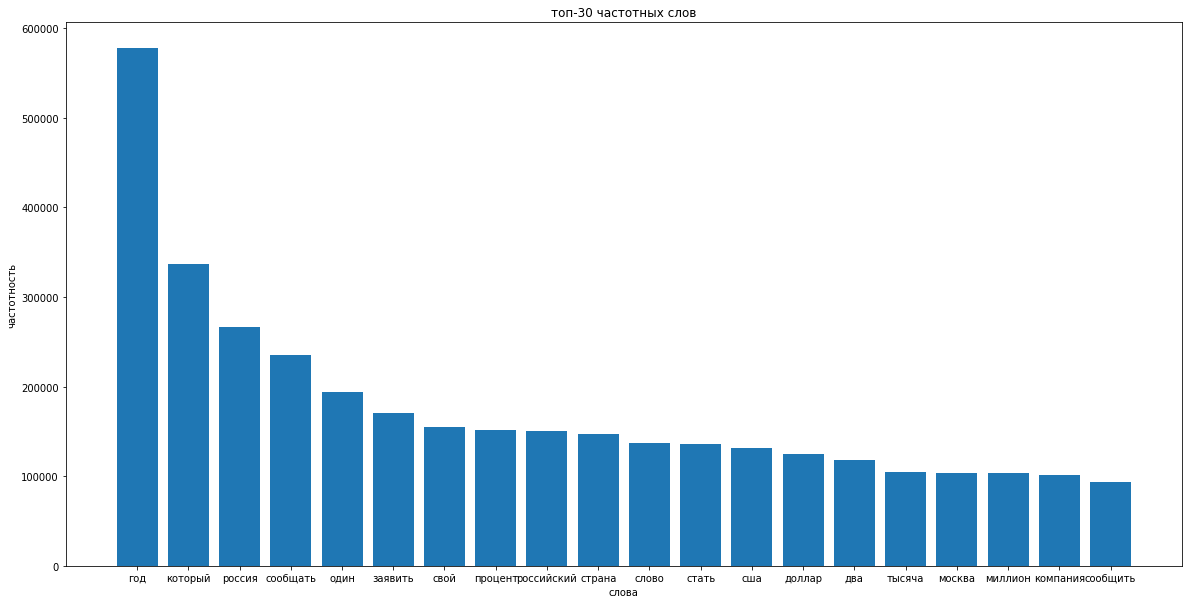

In [126]:
plot_frequency(vocab, 20)

In [70]:
%%time

lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(count_vect_train, y_train)

pred_lr = lr.predict(count_vect_test)
print(f'classification_report:\n{classification_report(y_test, pred_lr, digits=5, target_names=le.classes_)}')
print(f'\nconfusion_matrix:\n{confusion_matrix(y_test, pred_lr)}')

classification_report:
              precision    recall  f1-score   support

    Культура    0.53556   0.61777   0.57373     10703
         Мир    0.73148   0.71009   0.72063     27246
      Россия    0.76224   0.69100   0.72487     30922
       Спорт    0.63131   0.75300   0.68681     11579
   Экономика    0.73871   0.72962   0.73414     15271

    accuracy                        0.70190     95721
   macro avg    0.67986   0.70029   0.68803     95721
weighted avg    0.70855   0.70190   0.70364     95721


confusion_matrix:
[[ 6612   994  1082  1484   531]
 [ 1920 19347  3224  1444  1311]
 [ 1822  4144 21367  1696  1893]
 [ 1268   727   659  8719   206]
 [  724  1237  1700   468 11142]]
CPU times: user 1min 1s, sys: 21.3 ms, total: 1min 1s
Wall time: 1min 1s


### как видим, очистка текста улучшила метрики на несколько пунктов